#Time Series Analysis and Forecasting XAUUSD

## 1. Import Libary

In [1]:
# %pip install pandas numpy matplot seaborn statsmodels quantstats

In [2]:
# import libary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Analysis Time Series Data
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Forcast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#Forecast Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Reports
import quantstats as qs

import itertools
import warnings

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Import Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict Gold Price/XAU_1d_data.csv', sep=';')

df.columns = df.columns.str.lower()

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

print(df.head())
print(f"Null:\n{df.isna().sum()}")


             open   high    low  close  volume
date                                          
2004-06-11  384.0  384.8  382.8  384.1     272
2004-06-14  384.3  385.8  381.8  382.8    1902
2004-06-15  382.8  388.8  381.1  388.6    1951
2004-06-16  387.1  389.8  382.6  383.8    2014
2004-06-17  383.6  389.3  383.0  387.6    1568
Null:
open      0
high      0
low       0
close     0
volume    0
dtype: int64


##  3. TIME SERIES ANALYSIS

### 3.1 Visualization Price & Volume

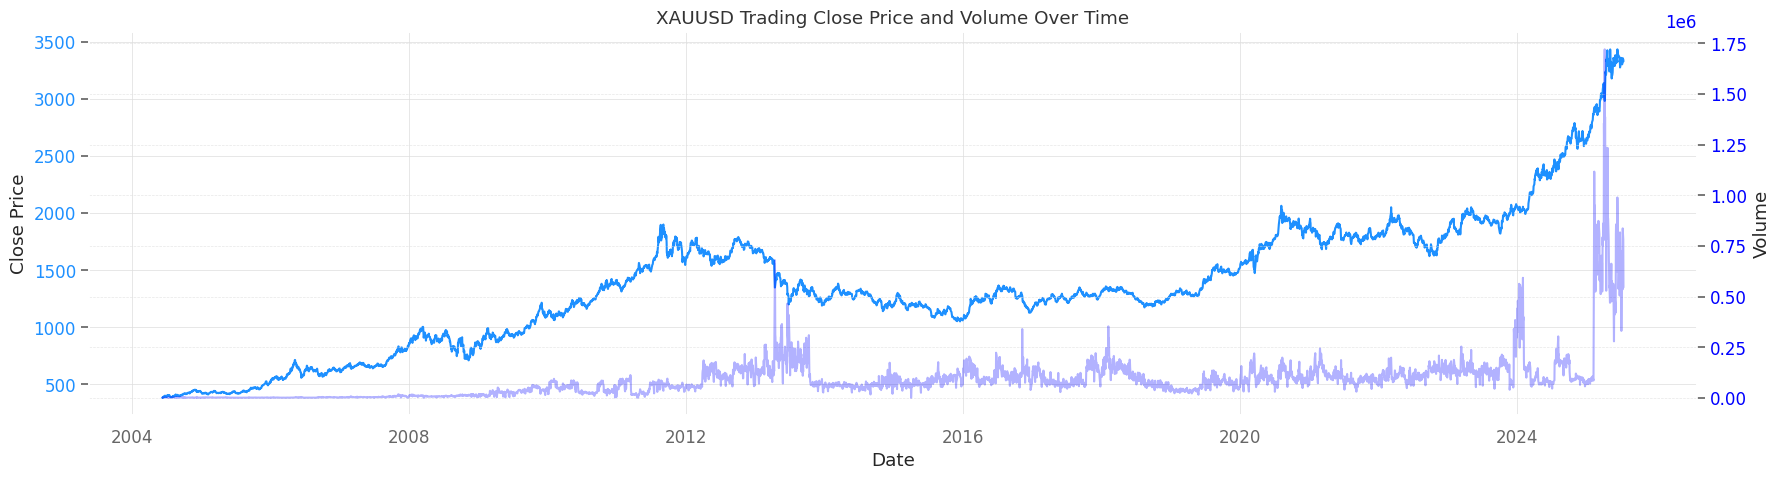

In [5]:
#Close and Volume on two y-axes
plt.figure(figsize=(18,5))

# Create the first y-axis for the close price
ax1 = plt.gca()
ax1.plot(df.index, df['close'], label='close', color='dodgerblue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price')
ax1.tick_params(axis='y', labelcolor='dodgerblue') # Match tick color to line color

# Create the second y-axis for the volume
ax2 = ax1.twinx()
ax2.plot(df.index, df['volume'], label='Volume', color='blue', alpha=0.3)
ax2.set_ylabel('Volume')
ax2.tick_params(axis='y', labelcolor='blue') # Match tick color to line color

plt.title('XAUUSD Trading Close Price and Volume Over Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 3.2 Trend - Cycle - Sesonal

<Figure size 1400x1000 with 0 Axes>

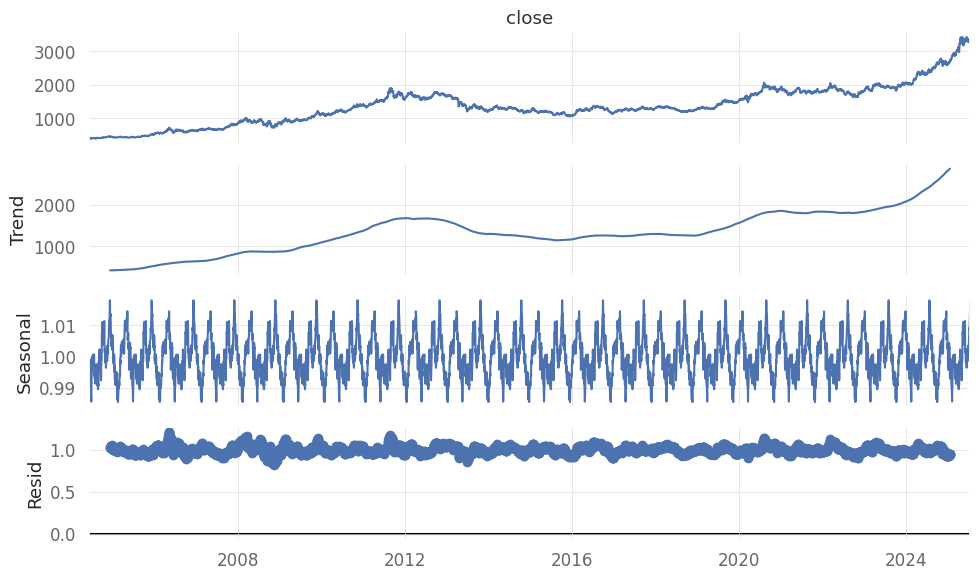

In [6]:
# Decompose the 'close' price series (using the Multiplicative model)
# We assume a periodicity of 252 (number of trading days in a year)
decomposition = seasonal_decompose(df['close'], model='multiplicative', period=252)

# Plot the decomposed components
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

### 3.3 Stationarity Test Results (Augmented Dickey-Fuller)
Augmented Dickey-Fuller (ADF) test to formally check this.
- Null Hypothesis ($H_0$): The time series is non-stationary (it has a unit root).
- Alternative Hypothesis ($H_1$​): The time series is stationary.

In [7]:
def adf_test(series):
    """Performs and prints the results of the ADF test."""
    print("--- Results of Augmented Dickey-Fuller Test ---")
    result = adfuller(series.dropna())

    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")

    if result[1] <= 0.05:
        print("Conclusion: Reject H0. The series is likely stationary.")
    else:
        print("Conclusion: Fail to Reject H0. The series is non-stationary.")

# Run the test on the 'close' price
adf_test(df['close'])

--- Results of Augmented Dickey-Fuller Test ---
ADF Statistic: 1.2942
p-value: 0.9966
Conclusion: Fail to Reject H0. The series is non-stationary.


- This means the gold (XAUUSD) closing price series is *non-stationary*, showing a trend and possibly *heteroskedasticity*.
- Non-stationarity implies the statistical properties (mean, variance) change over time, unsuitable for direct modeling with ARIMA or similar methods.

=> Hence, we proceed to difference the series to remove the trend.

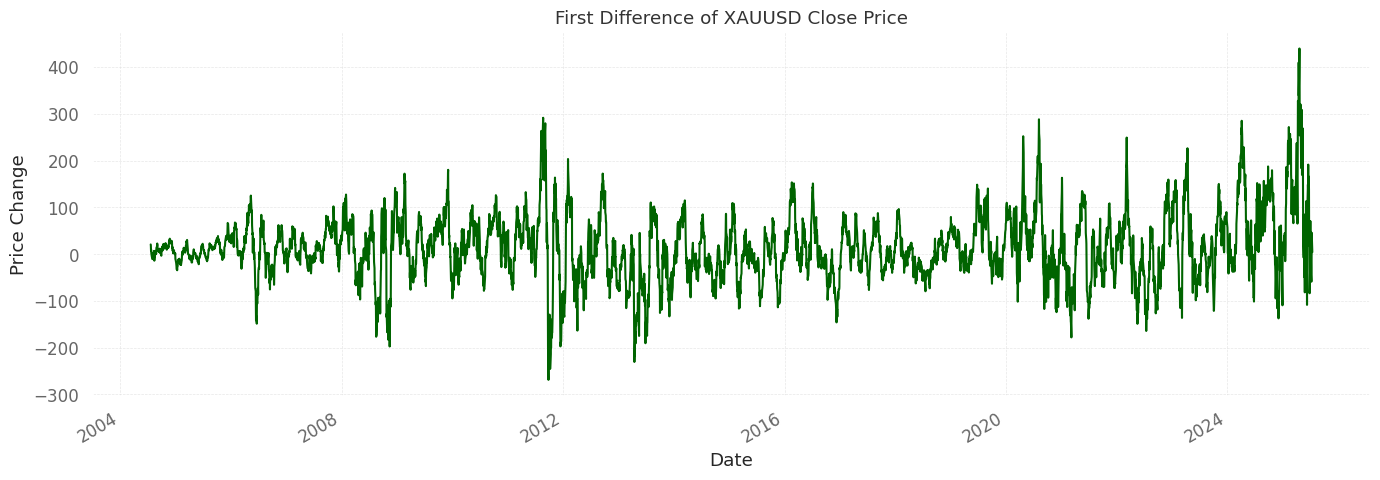


--- Testing Stationarity of the DIFFERENCED Series ---
--- Results of Augmented Dickey-Fuller Test ---
ADF Statistic: -8.6957
p-value: 0.0000
Conclusion: Reject H0. The series is likely stationary.


In [8]:
# Calculate the first difference of the close price
df['close_diff'] = df['close'].diff(periods=25)

# Plot the differenced series
plt.figure(figsize=(14, 5))
df['close_diff'].plot(title='First Difference of XAUUSD Close Price',
                      color='darkgreen',
                      linewidth=1.5)
plt.xlabel("Date")
plt.ylabel("Price Change")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Test the differenced series for stationarity
print("\n--- Testing Stationarity of the DIFFERENCED Series ---")
adf_test(df['close_diff'])

Differencing removes the long-term trend and stabilizes the mean.

- After differencing, the data now oscillates around zero, suggesting **constant variance** and **mean reversion**.

- This is a key transformation before using ARIMA/ or other forecasting models that require stationarity.

### 3.4 ACF and PACF of Differenced Series

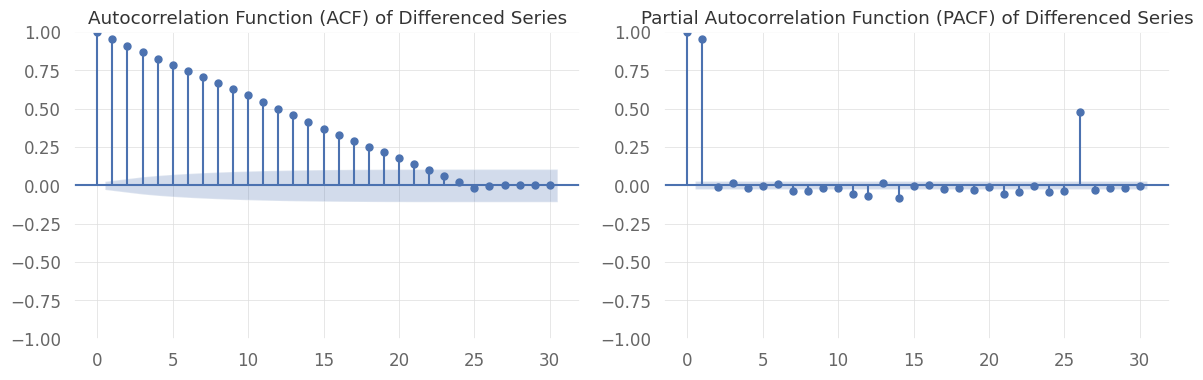

In [9]:
# Ensure you use the stationary series (the first difference)
stationary_series = df['close_diff'].dropna()

# Create plots for ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation Function (ACF) plot
plot_acf(stationary_series, lags=30, ax=axes[0], title='Autocorrelation Function (ACF) of Differenced Series')

# Partial Autocorrelation Function (PACF) plot
plot_pacf(stationary_series, lags=30, ax=axes[1], title='Partial Autocorrelation Function (PACF) of Differenced Series')

plt.tight_layout()
plt.show()

**Result:**
The ACF shows a slow, gradual decay while the PACF has a strong spike at lag 1 and quickly drops afterward.

**Explanation:**
- The slow decay in ACF indicates that the series follows an **autoregressive (AR)** process.  
- The sharp cutoff in PACF at lag 1 suggests an **AR(1)** model is appropriate.  
- Because the data was differenced to achieve stationarity, the suitable model is **ARIMA(1,1,0)**


## 4. Forecasting

In [10]:
# Split the data into training and testing sets (80/20)
train_size = int(len(df) * 0.8)
train_data = df[0:train_size].copy()
test_data = df[train_size:].copy()

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (4334, 6)
Test data shape: (1084, 6)


### 4.1. ARIMA Model

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 4334
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -17330.758
Date:                Mon, 27 Oct 2025   AIC                          34665.516
Time:                        08:29:49   BIC                          34678.264
Sample:                             0   HQIC                         34670.016
                               - 4334                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0111      0.010      1.115      0.265      -0.008       0.031
sigma2       174.4598      1.756     99.335      0.000     171.018     177.902
Ljung-Box (L1) (Q):                   0.00   Jarque-

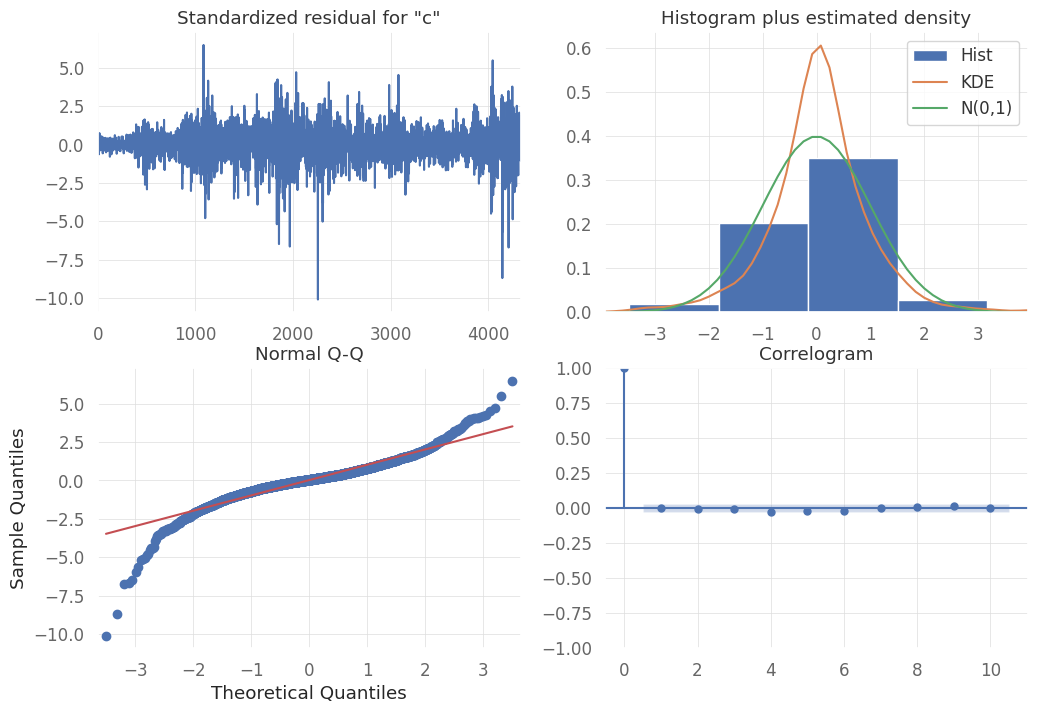

Mean Squared Error (MSE): 339118.0944
Root Mean Squared Error (RMSE): 582.3385
Mean Absolute Error (MAE): 376.3071
R-squared (R2): -0.6295


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [11]:
p, d, q = 1, 1, 0

# Fit the ARIMA model on the training data
model = ARIMA(train_data['close'], order=(p, d, q))
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# Make predictions on the test data
predictions = results.predict(start=len(train_data), end=len(df)-1)

# Ensure predictions align with the test_data index
predictions.index = test_data.index

# Calculate evaluation metrics
mse = mean_squared_error(test_data['close'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['close'], predictions)
r2 = r2_score(test_data['close'], predictions)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

### 4.2 SARIMA Model

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



--- SARIMA Model Metrics ---
Mean Squared Error (MSE): 339913.1371
Root Mean Squared Error (RMSE): 583.0207
Mean Absolute Error (MAE): 377.1070
R-squared (R2): -0.6333

Metrics stored for SARIMA model.
                                     SARIMAX Results                                      
Dep. Variable:                              close   No. Observations:                 4334
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 25)   Log Likelihood              -17330.167
Date:                            Mon, 27 Oct 2025   AIC                          34666.334
Time:                                    08:29:54   BIC                          34685.456
Sample:                                         0   HQIC                         34673.084
                                           - 4334                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025   

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


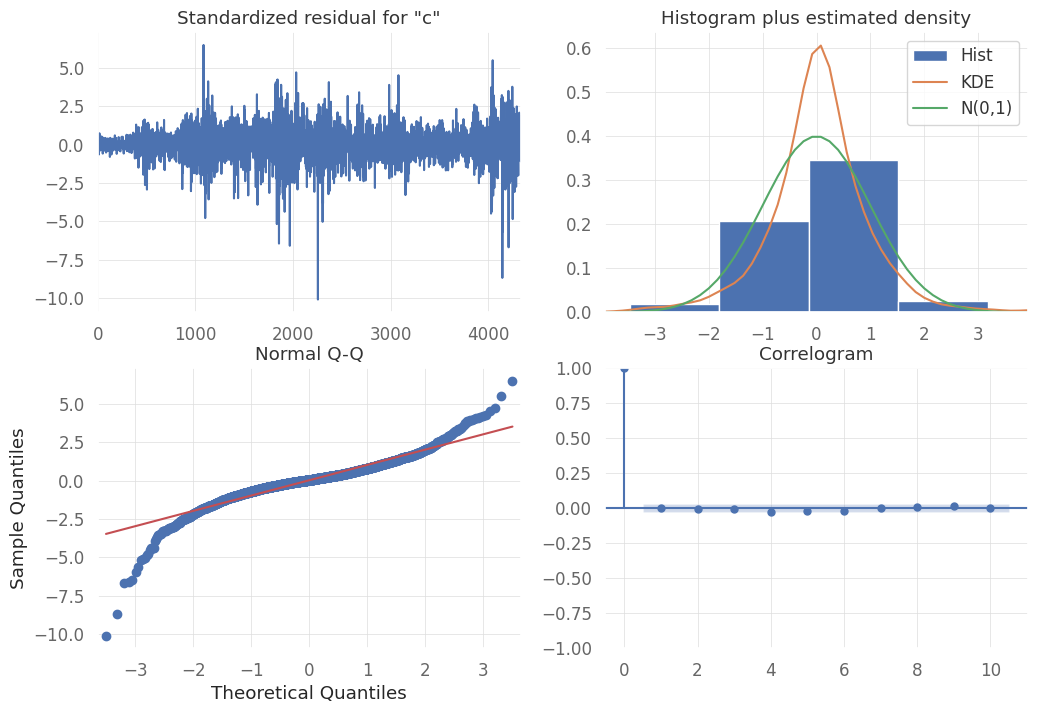

In [12]:
# Define a seasonal order (P, D, Q, s)
# s is the seasonal period. For monthly seasonality in daily data, s=25 (approx trading days).
seasonal_order = (1, 0, 0, 25)
P, D, Q, s = seasonal_order

try:
    # Instantiate the SARIMAX model
    sarima_model = SARIMAX(train_data['close'], order=(p, d, q), seasonal_order=(P, D, Q, s))

    # Fit the model
    sarima_results = sarima_model.fit()

    # Make predictions on the test data period
    sarima_predictions = sarima_results.predict(start=len(train_data), end=len(df)-1)

    # Ensure predictions align with the test_data index
    sarima_predictions.index = test_data.index

    # Calculate evaluation metrics for the SARIMA model
    sarima_mse = mean_squared_error(test_data['close'], sarima_predictions)
    sarima_rmse = np.sqrt(sarima_mse)
    sarima_mae = mean_absolute_error(test_data['close'], sarima_predictions)
    sarima_r2 = r2_score(test_data['close'], sarima_predictions)

    # Print the calculated evaluation metrics for the SARIMA model
    print("\n--- SARIMA Model Metrics ---")
    print(f"Mean Squared Error (MSE): {sarima_mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {sarima_rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {sarima_mae:.4f}")
    print(f"R-squared (R2): {sarima_r2:.4f}")

    # Store the calculated metrics in a dictionary
    sarima_metrics = {
        'MSE': sarima_mse,
        'RMSE': sarima_rmse,
        'MAE': sarima_mae,
        'R2': sarima_r2
    }
    print("\nMetrics stored for SARIMA model.")

except Exception as e:
    print(f"  Error fitting or predicting with SARIMA order ({p}, {d}, {q})x({P}, {D}, {Q}, {s}): {e}")
    sarima_metrics = {} # Store empty dict if error occurs

warnings.filterwarnings("default") # Reset warnings

print(sarima_results.summary())
sarima_results.plot_diagnostics(figsize=(12, 8))
plt.show()


### 4.3 Exponential Smoothing Model



In [13]:
# Choose an appropriate Exponential Smoothing model.
# Given the trend observed in the data but no obvious strong seasonality within a year (252 trading days),
# Holt's linear trend method might be a reasonable starting point, or a simple additive/multiplicative trend.
# Let's try Holt's linear trend method first, which is a form of Exponential Smoothing with trend.
# We set seasonal=None for this initial attempt.

# Instantiate the model
holt_model = ExponentialSmoothing(train_data['close'], trend='add', seasonal=None)

# Fit the model
holt_results = holt_model.fit()

# Make predictions
holt_predictions = holt_results.predict(start=len(train_data), end=len(df)-1)

# Ensure predictions align with the test_data index
holt_predictions.index = test_data.index

# Calculate and print evaluation metrics
holt_mse = mean_squared_error(test_data['close'], holt_predictions)
holt_rmse = np.sqrt(holt_mse)
holt_mae = mean_absolute_error(test_data['close'], holt_predictions)
holt_r2 = r2_score(test_data['close'], holt_predictions)

print("\n--- Exponential Smoothing (Holt's Linear Trend) Model Metrics ---")
print(f"Mean Squared Error (MSE): {holt_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {holt_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {holt_mae:.4f}")
print(f"R-squared (R2): {holt_r2:.4f}")

# Store the calculated metrics (assuming a dictionary `model_metrics` exists or create one)
# For now, let's just store them in a new dictionary for this model.
exponential_smoothing_metrics = {
    'MSE': holt_mse,
    'RMSE': holt_rmse,
    'MAE': holt_mae,
    'R2': holt_r2
}

print("\nMetrics stored for Exponential Smoothing model.")

print(holt_results.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



--- Exponential Smoothing (Holt's Linear Trend) Model Metrics ---
Mean Squared Error (MSE): 175020.2682
Root Mean Squared Error (RMSE): 418.3542
Mean Absolute Error (MAE): 251.8019
R-squared (R2): 0.1590

Metrics stored for Exponential Smoothing model.
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                 4334
Model:             ExponentialSmoothing   SSE                         755478.769
Optimized:                         True   AIC                          22375.171
Trend:                         Additive   BIC                          22400.668
Seasonal:                          None   AICC                         22375.190
Seasonal Periods:                  None   Date:                 Mon, 27 Oct 2025
Box-Cox:                          False   Time:                         08:29:56
Box-Cox Coeff.:                    None                                         
                 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 5. Data Evaluation

--- Model Performance Comparison ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,Model,MSE,RMSE,MAE,R2
0,"ARIMA (1,1,0)",339118.094395,582.338471,376.307138,-0.629507
1,Exponential Smoothing,175020.268220,418.354238,251.801853,0.159005
2,"SARIMA (1,1,0)x(1,0,0,25)",339913.137064,583.020700,377.107015,-0.633327


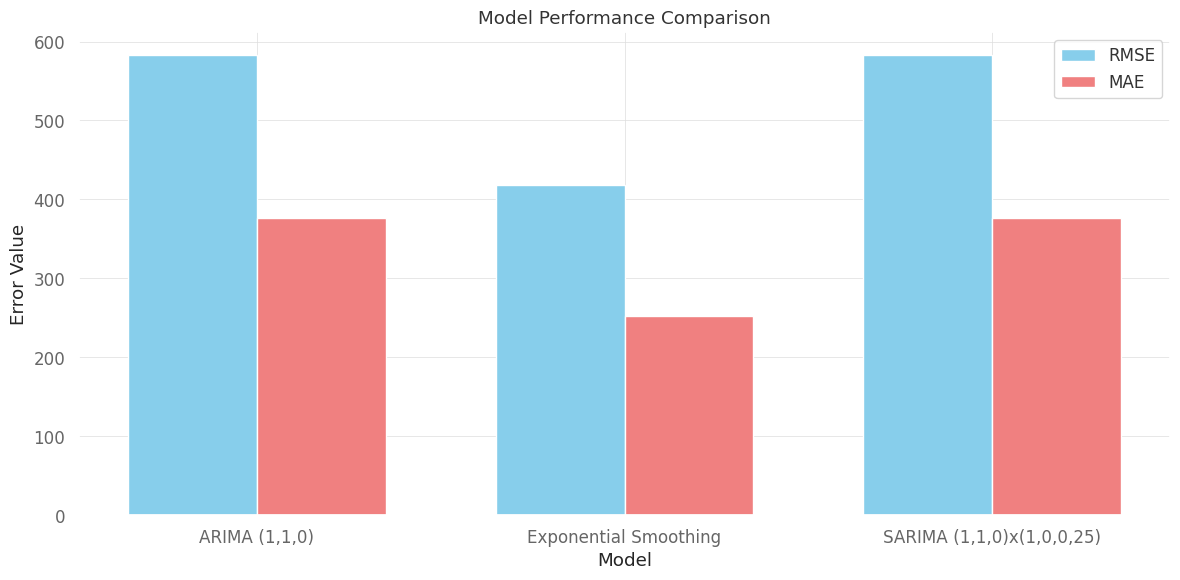

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [14]:
# We will compare the Initial ARIMA, Exponential Smoothing, and SARIMA models
metrics_data = {
    'Model': ['ARIMA (1,1,0)', 'Exponential Smoothing', 'SARIMA (1,1,0)x(1,0,0,25)'],
    'MSE': [mse, exponential_smoothing_metrics['MSE'], sarima_metrics['MSE']],
    'RMSE': [rmse, exponential_smoothing_metrics['RMSE'], sarima_metrics['RMSE']],
    'MAE': [mae, exponential_smoothing_metrics['MAE'], sarima_metrics['MAE']],
    'R2': [r2, exponential_smoothing_metrics['R2'], sarima_metrics['R2']]
}

# Create the comparison DataFrame
comparison_df = pd.DataFrame(metrics_data)

# Print the comparison DataFrame
print("--- Model Performance Comparison ---")
display(comparison_df)

# Create a bar plot to compare RMSE and MAE
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
index = np.arange(len(comparison_df['Model']))

bar1 = ax.bar(index, comparison_df['RMSE'], bar_width, label='RMSE', color='skyblue')
bar2 = ax.bar(index + bar_width, comparison_df['MAE'], bar_width, label='MAE', color='lightcoral')

ax.set_xlabel('Model')
ax.set_ylabel('Error Value')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()

plt.tight_layout()
plt.show()

## 6. Forecasting

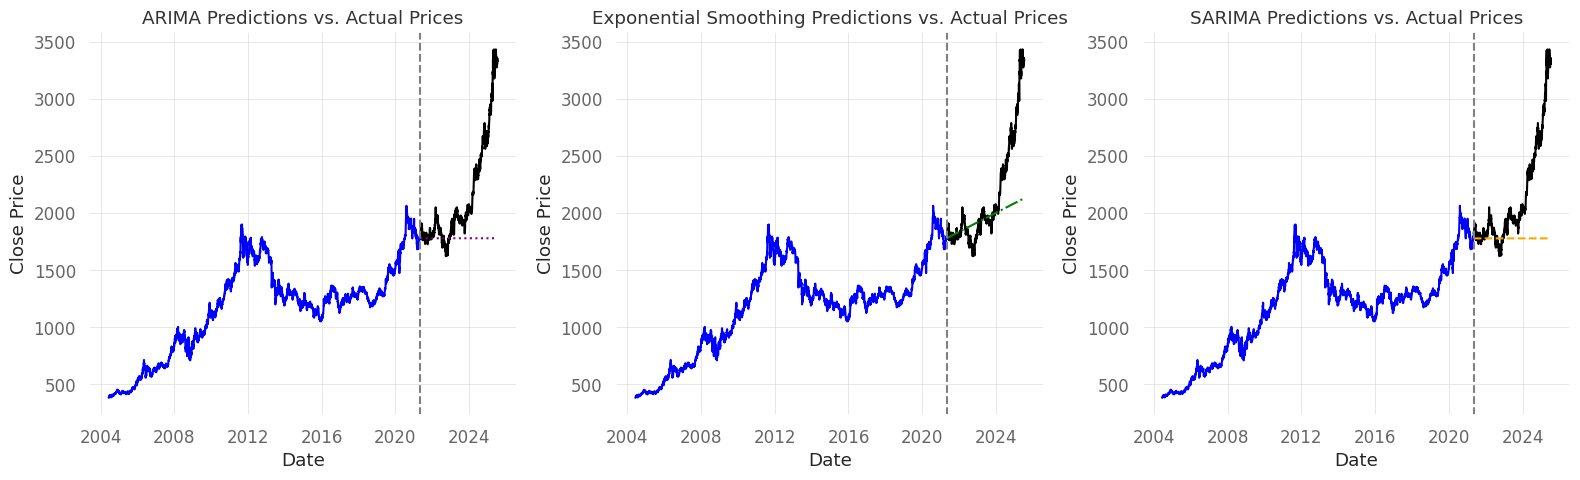

In [15]:
# Create a list of models, their predictions, and labels for plotting
models_to_plot = [
    {'predictions': predictions, 'label': 'ARIMA Predictions', 'color': 'purple', 'linestyle': ':'},
    {'predictions': holt_predictions, 'label': 'Exponential Smoothing Predictions', 'color': 'green', 'linestyle': '-.'},
    {'predictions': sarima_predictions, 'label': 'SARIMA Predictions', 'color': 'orange', 'linestyle': '--'}
]

# Determine the number of rows needed for x columns
n_models = len(models_to_plot)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Plot each model's predictions in a separate subplot
for i, model_info in enumerate(models_to_plot):
    ax = axes[i]

    # Plot actual prices (training and test data)
    ax.plot(train_data['close'].index, train_data['close'], label='Training Data', color='blue')
    ax.plot(test_data['close'].index, test_data['close'], label='Actual Prices (Test Data)', color='black')

    # Plot predictions from the current model
    ax.plot(test_data['close'].index, model_info['predictions'], label=model_info['label'], color=model_info['color'], linestyle=model_info['linestyle'])

    # Add a vertical line at the split point
    split_date = train_data.index[-1]
    ax.axvline(x=split_date, color='gray', linestyle='--', label='Train/Test Split')

    ax.set_title(f"{model_info['label']} vs. Actual Prices")
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 7. Backtesting

### 7.1 Prepare Data

In [18]:
# Define the trading strategy rules and generate signals for each model

# Work on a copy of test_data within this cell to avoid SettingWithCopyWarning
test_data_copy = test_data.copy()

# Shift the actual close prices to align yesterday's close with today's prediction
test_data_copy['previous_close'] = test_data_copy['close'].shift(1)

# Create dictionaries to store signals for each strategy type (Spot and Future)
signals_spot = {}
signals_future = {}

# --- Generate signals based on ARIMA predictions ---

# Spot Trade Signal (1 for Long, 0 otherwise)
# If prediction > previous_close, signal is 1 (Long), otherwise 0 (Flat/No Trade)
signals_spot['arima'] = (predictions > test_data_copy['previous_close']).astype(int)
test_data_copy['signal_arima_spot'] = signals_spot['arima']

# Future Trade Signal (1 for Long, -1 for Short - no neutral)
# Initialize as a Series of -1 (Short) with the same index as test_data_copy
signals_future['arima'] = pd.Series(-1, index=test_data_copy.index)
# Set Long signal (1) where prediction > previous close
signals_future['arima'][predictions > test_data_copy['previous_close']] = 1
test_data_copy['signal_arima_future'] = signals_future['arima']


# --- Generate signals based on SARIMA predictions ---

# Spot Trade Signal (1 for Long, 0 otherwise)
# If prediction > previous_close, signal is 1 (Long), otherwise 0 (Flat/No Trade)
signals_spot['sarima'] = (sarima_predictions > test_data_copy['previous_close']).astype(int)
test_data_copy['signal_sarima_spot'] = signals_spot['sarima']

# Future Trade Signal (1 for Long, -1 for Short - no neutral)
# Initialize as a Series of -1 (Short) with the same index as test_data_copy
signals_future['sarima'] = pd.Series(-1, index=test_data_copy.index)
# Set Long signal (1) where prediction > previous close
signals_future['sarima'][sarima_predictions > test_data_copy['previous_close']] = 1
test_data_copy['signal_sarima_future'] = signals_future['sarima']


# --- Generate signals based on Exponential Smoothing predictions ---

# Spot Trade Signal (1 for Long, 0 otherwise)
# If prediction > previous_close, signal is 1 (Long), otherwise 0 (Flat/No Trade)
signals_spot['exponential_smoothing'] = (holt_predictions > test_data_copy['previous_close']).astype(int)
test_data_copy['signal_exponential_smoothing_spot'] = signals_spot['exponential_smoothing']

# Future Trade Signal (1 for Long, -1 for Short - no neutral)
# Initialize as a Series of -1 (Short) with the same index as test_data_copy
signals_future['exponential_smoothing'] = pd.Series(-1, index=test_data_copy.index)
# Set Long signal (1) where prediction > previous close
signals_future['exponential_smoothing'][holt_predictions > test_data_copy['previous_close']] = 1
test_data_copy['signal_exponential_smoothing_future'] = signals_future['exponential_smoothing']

# Now, update the original test_data with the new columns from the copy
test_data = test_data_copy




/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [19]:
# 1. Calculate the daily returns of the 'close' price for the test_data
# This was already calculated in the previous Spot Trade section, no need to repeat.
test_data['daily_returns'] = test_data['close'].pct_change()

# 2. Calculate the strategy's daily returns for each model (Spot and Future Trade)
# Multiply the daily returns by the signal (1 for long, -1 for short, 0 for flat)
test_data['strategy_returns_arima_spot'] = test_data['daily_returns'] * test_data['signal_arima_spot']
test_data['strategy_returns_sarima_spot'] = test_data['daily_returns'] * test_data['signal_sarima_spot']
test_data['strategy_returns_exponential_smoothing_spot'] = test_data['daily_returns'] * test_data['signal_exponential_smoothing_spot']

test_data['strategy_returns_arima_future'] = test_data['daily_returns'] * test_data['signal_arima_future']
test_data['strategy_returns_sarima_future'] = test_data['daily_returns'] * test_data['signal_sarima_future']
test_data['strategy_returns_exponential_smoothing_future'] = test_data['daily_returns'] * test_data['signal_exponential_smoothing_future']

# 3. Calculate the cumulative returns for each strategy (Spot and Future Trade)
# Use cumprod() for cumulative returns from percentage changes (add 1 before cumprod and subtract 1 after)
# Handle potential NaNs from the first day's daily_returns by filling with 0 for the cumulative product calculation
test_data['cumulative_strategy_returns_arima_spot'] = (1 + test_data['strategy_returns_arima_spot'].fillna(0)).cumprod() - 1
test_data['cumulative_strategy_returns_sarima_spot'] = (1 + test_data['strategy_returns_sarima_spot'].fillna(0)).cumprod() - 1
test_data['cumulative_strategy_returns_exponential_smoothing_spot'] = (1 + test_data['strategy_returns_exponential_smoothing_spot'].fillna(0)).cumprod() - 1

test_data['cumulative_strategy_returns_arima_future'] = (1 + test_data['strategy_returns_arima_future'].fillna(0)).cumprod() - 1
test_data['cumulative_strategy_returns_sarima_future'] = (1 + test_data['strategy_returns_sarima_future'].fillna(0)).cumprod() - 1
test_data['cumulative_strategy_returns_exponential_smoothing_future'] = (1 + test_data['strategy_returns_exponential_smoothing_future'].fillna(0)).cumprod() - 1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 7.2 Visualize backtesting results

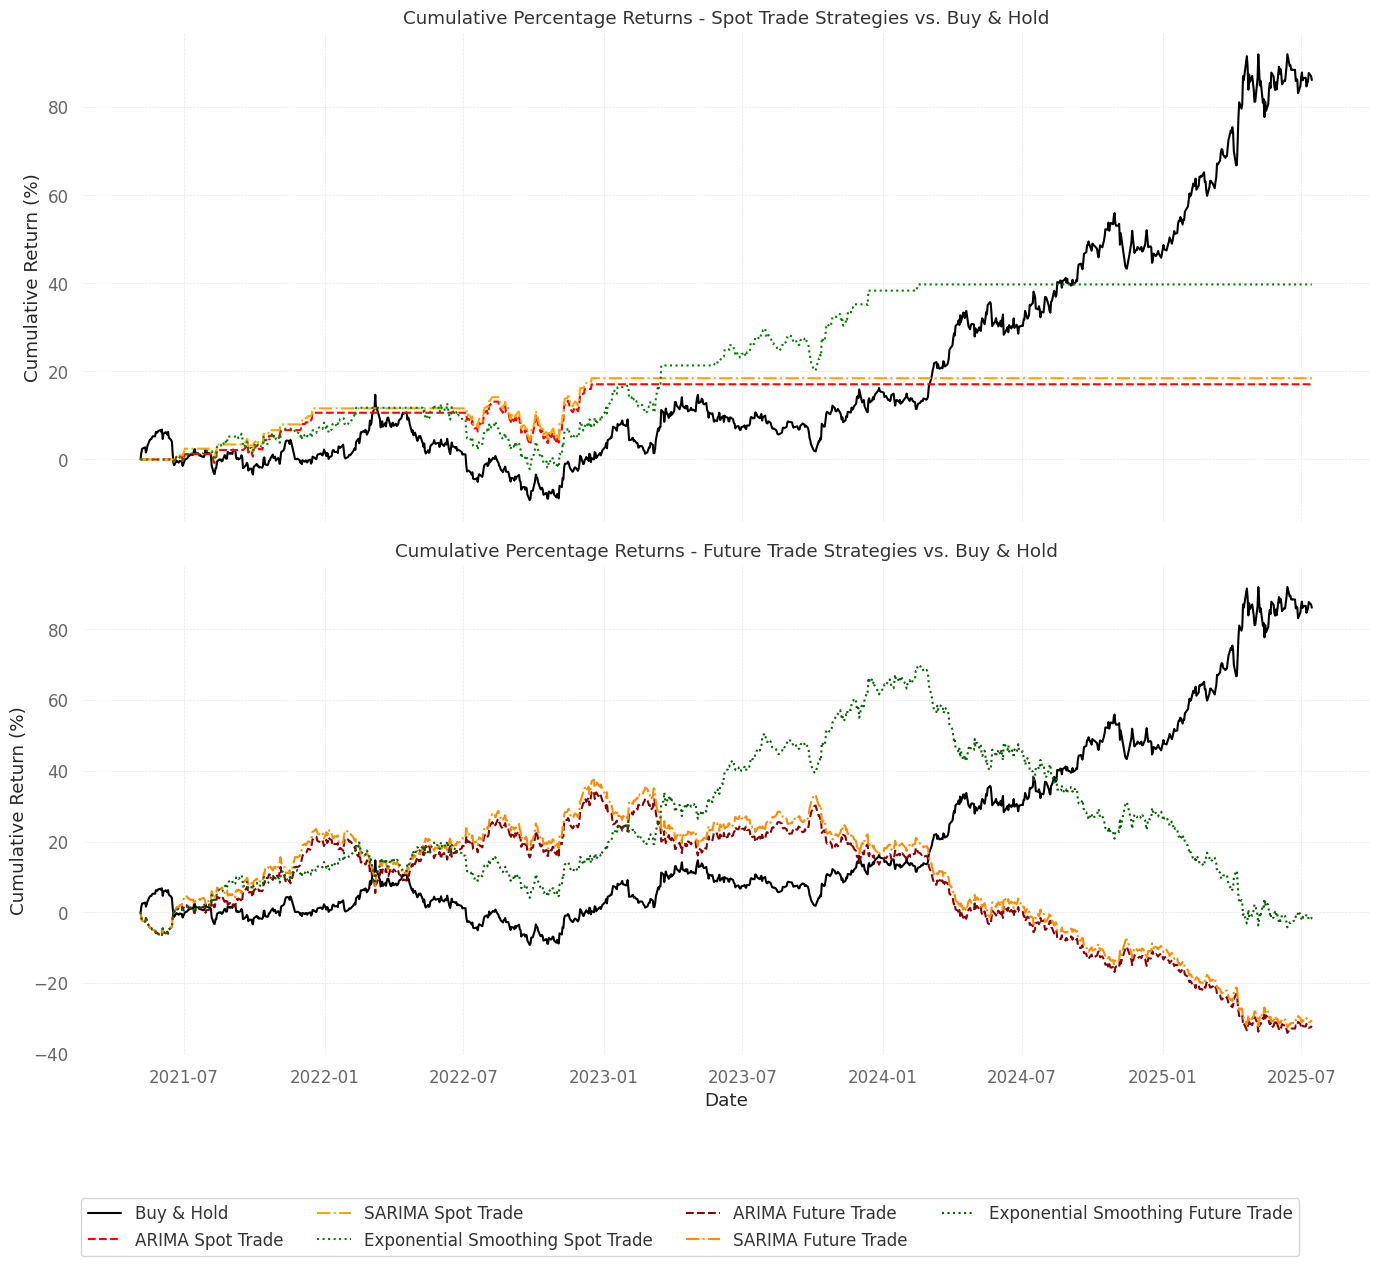

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [20]:
# Calculate Cumulative Percentage Return for Buy & Hold (Actual Prices)
# Start from the first day's price in the test set
initial_price_test_set = test_data['close'].iloc[0]
test_data['buy_and_hold_cumulative_return'] = (test_data['close'] / initial_price_test_set) - 1

# Create a figure with two subplots (one column, two rows)
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True) # Share x-axis

# --- Plot Spot Trade Strategies ---
ax1 = axes[0]
ax1.plot(test_data.index, test_data['buy_and_hold_cumulative_return'] * 100, label='Buy & Hold', color='black')
ax1.plot(test_data.index, test_data['cumulative_strategy_returns_arima_spot'] * 100, label='ARIMA Spot Trade', color='red', linestyle='--')
ax1.plot(test_data.index, test_data['cumulative_strategy_returns_sarima_spot'] * 100, label='SARIMA Spot Trade', color='orange', linestyle='-.')
ax1.plot(test_data.index, test_data['cumulative_strategy_returns_exponential_smoothing_spot'] * 100, label='Exponential Smoothing Spot Trade', color='green', linestyle=':')
ax1.set_title('Cumulative Percentage Returns - Spot Trade Strategies vs. Buy & Hold')
ax1.set_ylabel('Cumulative Return (%)')
ax1.grid(True, linestyle='--', alpha=0.7)


# --- Plot Future Trade Strategies ---
ax2 = axes[1]
ax2.plot(test_data.index, test_data['buy_and_hold_cumulative_return'] * 100, label='Buy & Hold', color='black') # Include Buy & Hold again for context in the second plot
ax2.plot(test_data.index, test_data['cumulative_strategy_returns_arima_future'] * 100, label='ARIMA Future Trade', color='darkred', linestyle='--')
ax2.plot(test_data.index, test_data['cumulative_strategy_returns_sarima_future'] * 100, label='SARIMA Future Trade', color='darkorange', linestyle='-.')
ax2.plot(test_data.index, test_data['cumulative_strategy_returns_exponential_smoothing_future'] * 100, label='Exponential Smoothing Future Trade', color='darkgreen', linestyle=':')
ax2.set_title('Cumulative Percentage Returns - Future Trade Strategies vs. Buy & Hold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Return (%)')
ax2.grid(True, linestyle='--', alpha=0.7)

# Create a single legend for both plots
# Collect handles and labels from both axes
handles, labels = [], []
for ax in axes:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        # Avoid duplicate 'Buy & Hold' labels in the final legend
        if label not in labels:
            handles.append(handle)
            labels.append(label)

# Add the combined legend to the figure
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=4) # Adjust legend position

plt.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make space for the legend at the bottom
plt.show()

--- QuantStats Basic Stats for ARIMA Strategy (Spot Trade) ---
[Performance Metrics]



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                     Strategy
-------------------  ----------
Start Period         2021-05-06
End Period           2025-07-15
Risk-Free Rate       0.0%
Time in Market       14.0%

Cumulative Return    17.06%
CAGR﹪               3.73%

Sharpe               0.72
Prob. Sharpe Ratio   93.95%
Sortino              1.2
Sortino/√2           0.85
Omega                1.39

Max Drawdown         -8.62%
Max DD Date          2022-09-26
Max DD Period Start  2022-08-17
Max DD Period End    2022-11-14
Longest DD Days      90

Gain/Pain Ratio      0.39
Gain/Pain (1M)       2.76

Payoff Ratio         1.11
Profit Factor        1.39
Common Sense Ratio   3.21
CPC Index            0.86
Tail Ratio           2.32
Outlier Win Ratio    25.45
Outlier Loss Ratio   1.83

MTD                  0.0%
3M                   0.0%
6M                   0.0%
YTD                  0.0%
1Y                   0.0%
3Y (ann.)            1.15%
5Y (ann.)            3.73%
10Y (ann.)           3.73%
All-time (ann.)      3.73%

Avg. Dra

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


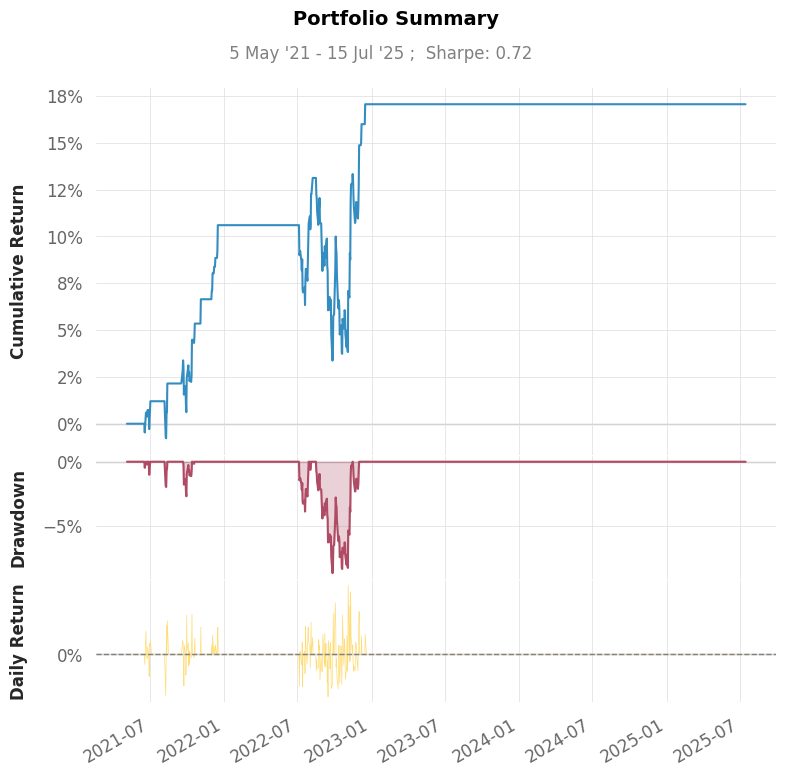

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


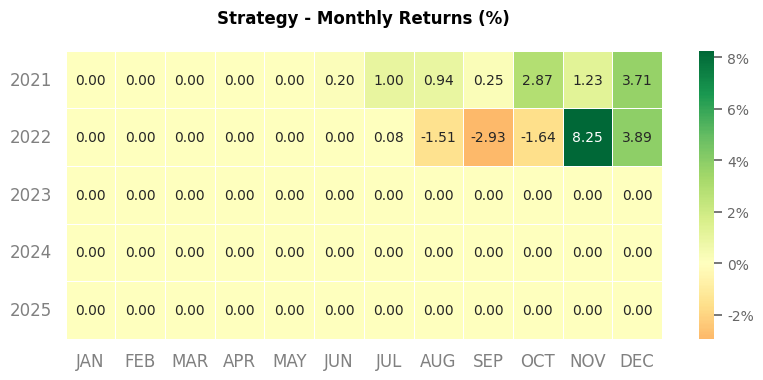


--- QuantStats Basic Stats for SARIMA Strategy (Spot Trade) ---
[Performance Metrics]



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                     Strategy
-------------------  ----------
Start Period         2021-05-06
End Period           2025-07-15
Risk-Free Rate       0.0%
Time in Market       14.0%

Cumulative Return    18.44%
CAGR﹪               4.02%

Sharpe               0.77
Prob. Sharpe Ratio   95.32%
Sortino              1.31
Sortino/√2           0.92
Omega                1.43

Max Drawdown         -8.62%
Max DD Date          2022-09-26
Max DD Period Start  2022-08-17
Max DD Period End    2022-11-14
Longest DD Days      90

Gain/Pain Ratio      0.43
Gain/Pain (1M)       2.96

Payoff Ratio         1.09
Profit Factor        1.43
Common Sense Ratio   3.79
CPC Index            0.88
Tail Ratio           2.65
Outlier Win Ratio    25.69
Outlier Loss Ratio   1.78

MTD                  0.0%
3M                   0.0%
6M                   0.0%
YTD                  0.0%
1Y                   0.0%
3Y (ann.)            1.25%
5Y (ann.)            4.02%
10Y (ann.)           4.02%
All-time (ann.)      4.02%

Avg. Dr

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


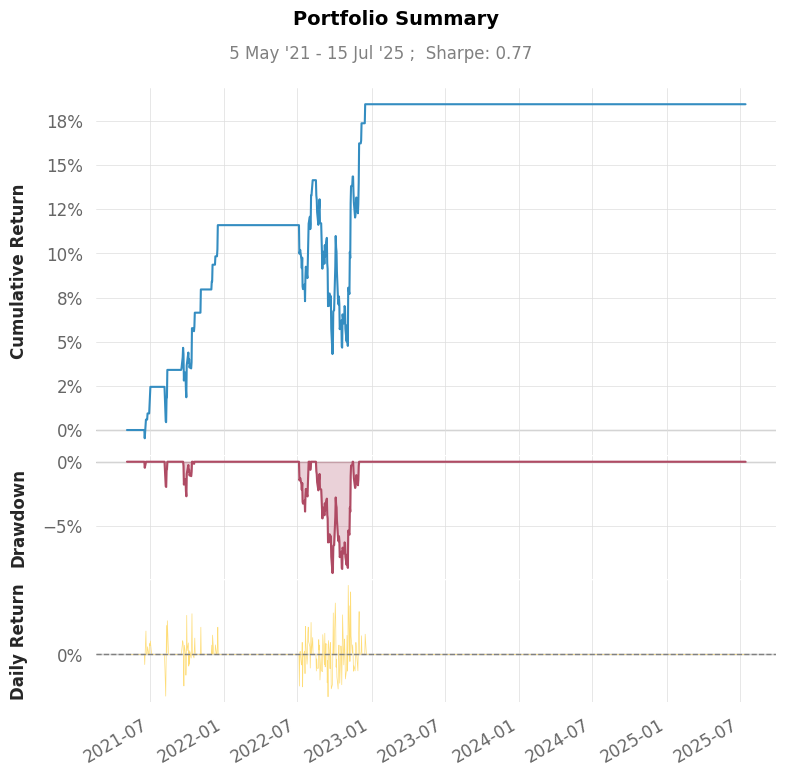

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


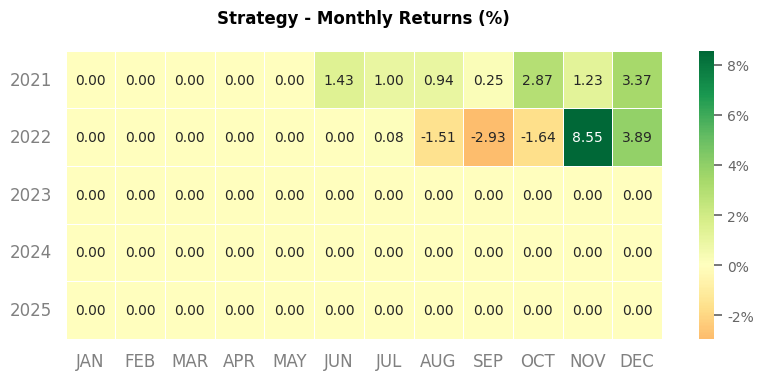


--- QuantStats Basic Stats for Exponential Smoothing Strategy (Spot Trade) ---
[Performance Metrics]



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                     Strategy
-------------------  ----------
Start Period         2021-05-06
End Period           2025-07-15
Risk-Free Rate       0.0%
Time in Market       43.0%

Cumulative Return    39.72%
CAGR﹪               8.09%

Sharpe               0.95
Prob. Sharpe Ratio   97.76%
Sortino              1.51
Sortino/√2           1.07
Omega                1.29

Max Drawdown         -13.31%
Max DD Date          2022-09-26
Max DD Period Start  2022-06-13
Max DD Period End    2023-01-06
Longest DD Days      208

Gain/Pain Ratio      0.29
Gain/Pain (1M)       1.39

Payoff Ratio         1.16
Profit Factor        1.29
Common Sense Ratio   1.57
CPC Index            0.79
Tail Ratio           1.22
Outlier Win Ratio    10.22
Outlier Loss Ratio   2.82

MTD                  0.0%
3M                   0.0%
6M                   0.0%
YTD                  0.0%
1Y                   0.0%
3Y (ann.)            8.81%
5Y (ann.)            8.09%
10Y (ann.)           8.09%
All-time (ann.)      8.09%

Avg. 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


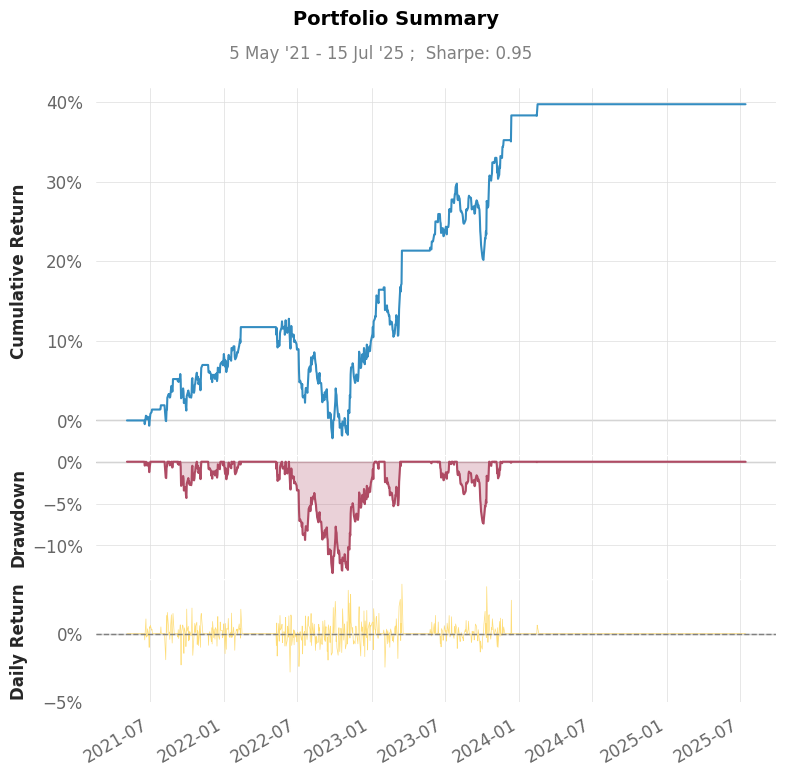

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


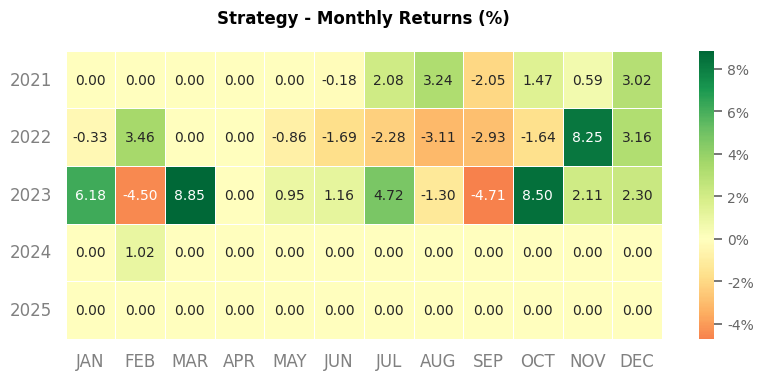


--- QuantStats Basic Stats for ARIMA Strategy (Future Trade) ---
[Performance Metrics]



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                     Strategy
-------------------  ----------
Start Period         2021-05-06
End Period           2025-07-15
Risk-Free Rate       0.0%
Time in Market       100.0%

Cumulative Return    -32.12%
CAGR﹪               -8.62%

Sharpe               -0.54
Prob. Sharpe Ratio   13.28%
Sortino              -0.75
Sortino/√2           -0.53
Omega                0.91

Max Drawdown         -50.94%
Max DD Date          2025-06-13
Max DD Period Start  2022-12-20
Max DD Period End    2025-07-15
Longest DD Days      939

Gain/Pain Ratio      -0.09
Gain/Pain (1M)       -0.33

Payoff Ratio         0.97
Profit Factor        0.91
Common Sense Ratio   0.96
CPC Index            0.43
Tail Ratio           1.06
Outlier Win Ratio    3.63
Outlier Loss Ratio   3.47

MTD                  -0.8%
3M                   -4.66%
6M                   -21.06%
YTD                  -22.65%
1Y                   -29.74%
3Y (ann.)            -18.39%
5Y (ann.)            -8.62%
10Y (ann.)           -8.62%
All-time (

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


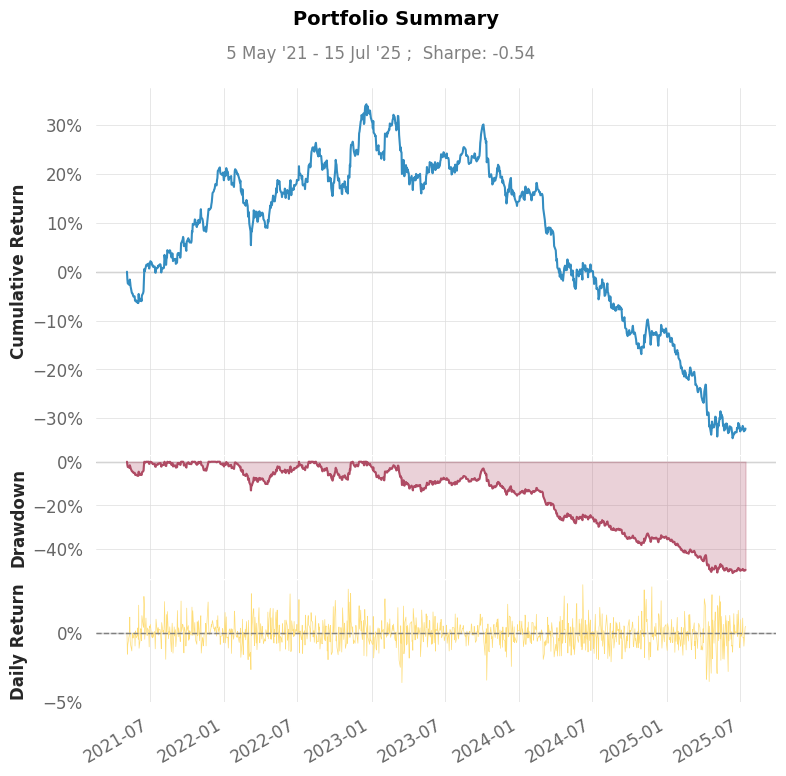

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


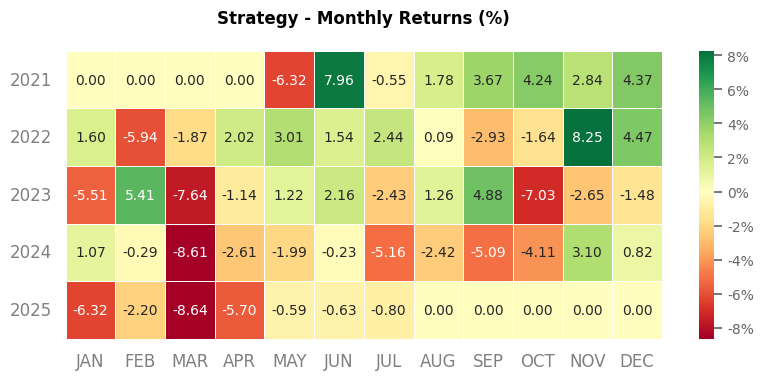


--- QuantStats Basic Stats for SARIMA Strategy (Future Trade) ---
[Performance Metrics]



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                     Strategy
-------------------  ----------
Start Period         2021-05-06
End Period           2025-07-15
Risk-Free Rate       0.0%
Time in Market       100.0%

Cumulative Return    -30.52%
CAGR﹪               -8.12%

Sharpe               -0.5
Prob. Sharpe Ratio   14.98%
Sortino              -0.7
Sortino/√2           -0.5
Omega                0.92

Max Drawdown         -50.94%
Max DD Date          2025-06-13
Max DD Period Start  2022-12-20
Max DD Period End    2025-07-15
Longest DD Days      939

Gain/Pain Ratio      -0.08
Gain/Pain (1M)       -0.31

Payoff Ratio         0.97
Profit Factor        0.92
Common Sense Ratio   0.97
CPC Index            0.43
Tail Ratio           1.06
Outlier Win Ratio    3.64
Outlier Loss Ratio   3.46

MTD                  -0.8%
3M                   -4.66%
6M                   -21.06%
YTD                  -22.65%
1Y                   -29.74%
3Y (ann.)            -18.24%
5Y (ann.)            -8.12%
10Y (ann.)           -8.12%
All-time (ann

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


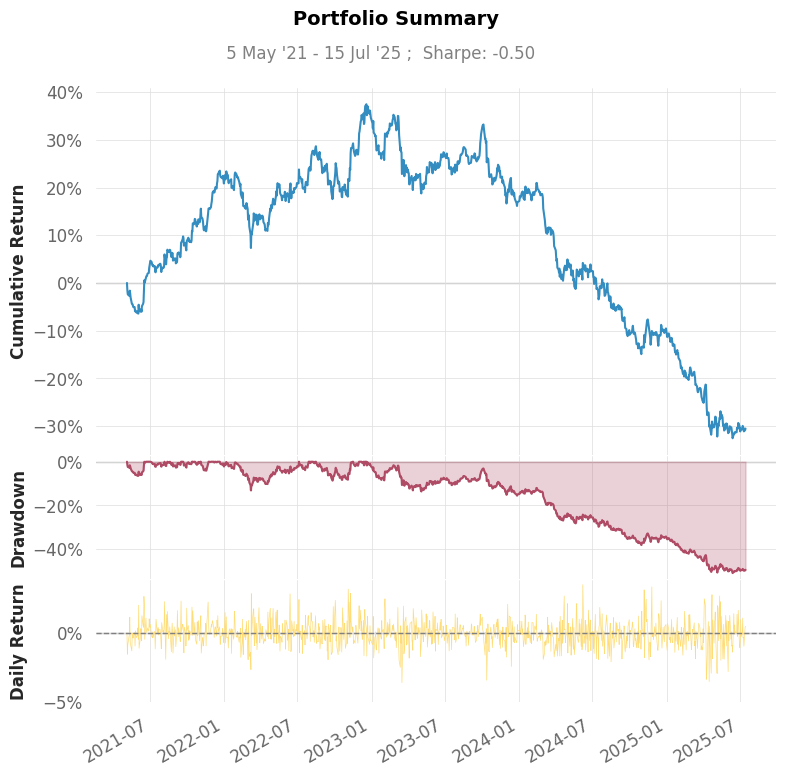

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


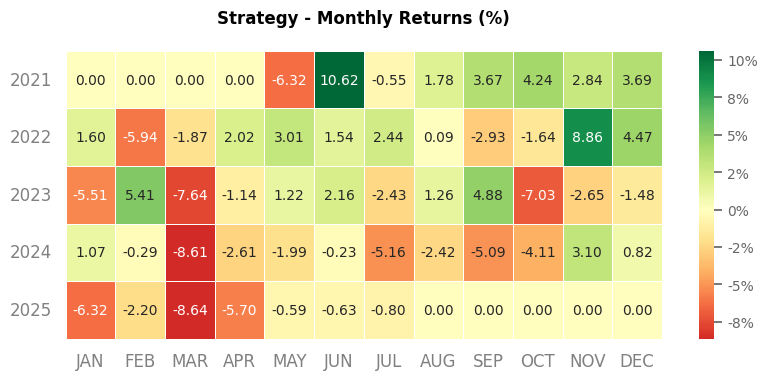


--- QuantStats Basic Stats for Exponential Smoothing Strategy (Future Trade) ---
[Performance Metrics]



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                     Strategy
-------------------  ----------
Start Period         2021-05-06
End Period           2025-07-15
Risk-Free Rate       0.0%
Time in Market       100.0%

Cumulative Return    -1.35%
CAGR﹪               -0.32%

Sharpe               0.05
Prob. Sharpe Ratio   54.29%
Sortino              0.08
Sortino/√2           0.05
Omega                1.01

Max Drawdown         -43.66%
Max DD Date          2025-06-13
Max DD Period Start  2024-02-19
Max DD Period End    2025-07-15
Longest DD Days      513

Gain/Pain Ratio      0.01
Gain/Pain (1M)       0.04

Payoff Ratio         1.05
Profit Factor        1.01
Common Sense Ratio   1.09
CPC Index            0.52
Tail Ratio           1.08
Outlier Win Ratio    3.7
Outlier Loss Ratio   3.41

MTD                  -0.8%
3M                   -4.66%
6M                   -21.06%
YTD                  -22.65%
1Y                   -29.74%
3Y (ann.)            -5.17%
5Y (ann.)            -0.32%
10Y (ann.)           -0.32%
All-time (ann.)   

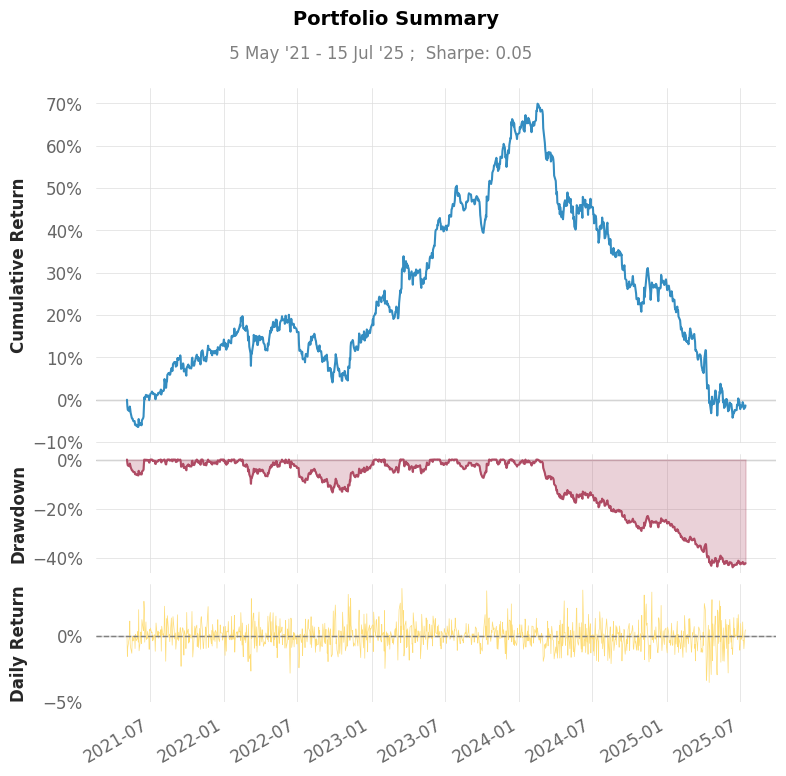

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


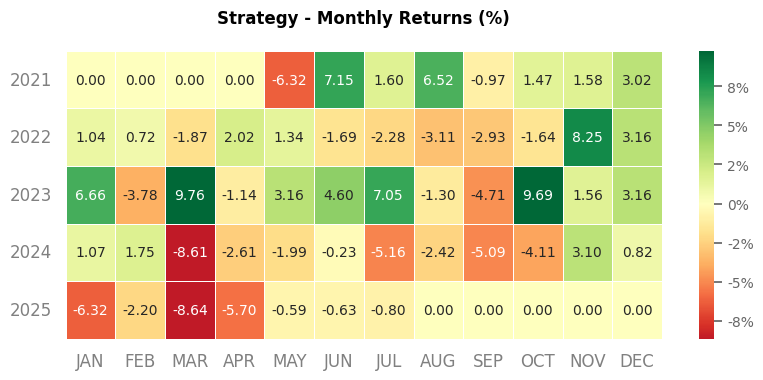

In [21]:

# Generate basic QuantStats reports (stats) for each Spot Trade strategy
print("--- QuantStats Basic Stats for ARIMA Strategy (Spot Trade) ---")
qs.reports.basic(test_data['strategy_returns_arima_spot'])

print("\n--- QuantStats Basic Stats for SARIMA Strategy (Spot Trade) ---")
qs.reports.basic(test_data['strategy_returns_sarima_spot'])

print("\n--- QuantStats Basic Stats for Exponential Smoothing Strategy (Spot Trade) ---")
qs.reports.basic(test_data['strategy_returns_exponential_smoothing_spot'])

# Generate basic QuantStats reports (stats) for each Future Trade strategy
print("\n--- QuantStats Basic Stats for ARIMA Strategy (Future Trade) ---")
qs.reports.basic(test_data['strategy_returns_arima_future'])

print("\n--- QuantStats Basic Stats for SARIMA Strategy (Future Trade) ---")
qs.reports.basic(test_data['strategy_returns_sarima_future'])

print("\n--- QuantStats Basic Stats for Exponential Smoothing Strategy (Future Trade) ---")
qs.reports.basic(test_data['strategy_returns_exponential_smoothing_future'])

# Note: Use qs.reports.html() for full reports.

## 8. Final Conclusion and Recommendation

This project involved analyzing historical XAUUSD (Gold) price data, applying time series forecasting models (ARIMA, SARIMA, Exponential Smoothing), and backtesting simple trading strategies based on the models' predictions.

### Summary of Findings:

1.  **Data Analysis**: The XAUUSD close price series was found to be non-stationary, which was addressed by first-order differencing.
2.  **Model Forecasting Performance**: Based on evaluation metrics (MSE, RMSE, MAE, R2) on the test set, the **Exponential Smoothing (Holt's Linear Trend) model** demonstrated the best forecasting accuracy among the models evaluated, with significantly lower error metrics and a positive R2. The ARIMA and SARIMA models, in their current configuration, showed poor forecasting performance with high error metrics and negative R2 values.
3.  **Backtesting Performance**: We backtested two types of daily trading strategies (Spot Trade: Long/Flat; Future Trade: Long/Short) based on the predictions of each model. The backtesting metrics (Total Return, Annualized Return, Sharpe Ratio, Drawdown, etc.) provided insights into the potential profitability and risk of each strategy.

    *   **Spot Trade Strategies**: All Spot Trade strategies based on the evaluated models resulted in positive Total and Annualized Returns over the backtesting period. The **Exponential Smoothing Spot Trade strategy** showed the highest Total Return (0.3972) and Annualized Return (0.0809) among the Spot Trade strategies, with a Sharpe Ratio of 0.9394.
    *   **Future Trade Strategies**: The Future Trade strategies, which allowed for shorting, generally showed negative Total and Annualized Returns across all models in this backtest. This indicates that the models' predictions, when used for both long and short signals with this specific strategy rule, did not perform well in capturing profitable shorting opportunities during this test period. The Maximum Drawdowns were also significant for some Future Trade strategies.

### Recommendation:

Based on both the model forecasting accuracy and the backtesting performance:

*   The **Exponential Smoothing (Holt's Linear Trend) model** appears to be the most suitable forecasting model among those tested for predicting XAUUSD close prices, exhibiting the best forecasting metrics.
*   The **Exponential Smoothing Spot Trade strategy** (Long/Flat based on Exponential Smoothing predictions) was the best-performing trading strategy in the backtest, offering positive returns and a reasonable Sharpe Ratio.
